*April 2021*
Representation and Interaction

## Multiagent search of lost targets 2D in a static world using range sensors (I)

**Author**: Pablo Lanillos Donders Institute

**IMPORTANT -**  This notebook goal is to introduce the problem and to create the some of the functions needed for the practical assigment

*In this notebook*

    a) Modelling the problem: environment, agent and sensor 
    b) One agent search greedy 1 step discrete

*In the next notebook*
1. Multiagent search greedy 1 step discrete no communication
2. Multiagent search greedy 1 step discrete common belief
3. Multiagent search n-step continuous optimization (centralized)


**References**: 
- Lanillos, P. (2013): Minimum time search of moving targets in uncertain environments. Ph.D. Dissertation. url: 
http://www.therobotdecision.com/papers/PhD_MinimumTimeSearch_2013_FinalElectronic_English_PabloLanillos.pdf

*Continuous*
- Lanillos, P., Gan, S. K., Besada-Portas, E., Pajares, G., & Sukkarieh, S. (2014). Multi-UAV target search using decentralized gradient-based negotiation with expected observation. Information Sciences, 282, 92-110.

*Discrete*
- Lanillos, P., Besada-Portas, E., Pajares, G., & Ruz, J. J. (2012, October). Minimum time search for lost targets using cross entropy optimization. In 2012 IEEE/RSJ International Conference on Intelligent Robots and Systems (pp. 602-609). IEEE.


### A small introduction tale
There  is  no  doubt, I  have lost my keys again, I’m late and I don’t know where to start the search. I evaluate the alternatives.  I usually leave them at the entrance hall, hanging from that screw that I put in a provisional eternal way.  They can also be in the bedroom, inside the Cairo bowl or inside the jeans pocket, which I have used yesterday.  Rationally, the most coherent action is to look first at the hall, but in the case that the keys are not there, I have to come back and that is a great time-wasting.  I only have ten minutes left to pick up the high speed train to Barcelona.  Therefore, I finally decide to watch in the bowl first and afterwards inside the jeans, and if I don’t find them I will look at the screw, which is on my way out. 
<img src="img/irritated-man-on-a-train.png" width="200" style="float: right;" />



Already  heading  Barcelona,  inside  the  train  and  without  the  keys,  I  think  about  my decision.  I really don’t know if my searching strategy has been optimal. Served with a coffee at the dining car, I write down the different options that I had this morning to prove that I have made the correct decision.  The problem started with the subjective information about the keys location: high  probability  of  finding  them  at  the  hall  and  medium  probability  of  finding  them in  the  jeans  and  the  bowl.   If  I  can  quantify  that  information,  the  only  thing  I  have to  determine  is  which  searching  path  is  the  best.   Thus,  I  need  the  actions  sequence that gives maximum probability of finding the keys, which is the same to look for the sequence that gives minimum probability of not finding them.  I raise my gaze and I take pleasure of my own explanation.  

The train car is getting full of people, maybe because it is lunch time. I stare again at my sheet full of hieroglyph and I continue engrossed in my task.  After doing some math, I check that ordering the places from greater to less probability and visiting them according to that order could be the best strategy. While I bite my green pen with anxiety, I discover that the method doesn’t always work and more questions arrive without an answer:  What happens if the time is critical? What if we are several people? And what about if already choosing a decision the alternatives change?...  But the fact that make me  feel  unease  is  to  think  that  even  making  the  right  decisions,  why  haven’t I found the keys? Once in  my  seat,  with  the  eyes  wide  shut  and  a  little  bit  sleepy,  I  receive  a  message on my cellphone that says:  - *remember that I took the keys to water the plants. When you come back, please call me.  Kisses* -.

### Description of the problem

<img src="img/problem-definition.png" width="400" style="float: left;" />
There is a shipwreck alert. We need to find the survivors but we do not have so much time. We count with a fleet of Unmanned Air Vehicles (UAVs) with sensors on board. We also have an initial guess of the possible areas where the survivors can be, such as a probability of finding the survivors. For simplicity we are going to do a strong assumption: the location of the survivors is constant. In other words, the world is static or the targets (survivors) do not have dynamics.

**The goal of this assignment is to program an algorithm that let multiple searching agents to find the survivors as soon as possible.** In other words, the algorithm should compute the optimal actions for the UAVs.

<img src="img/shipwreck.png" width="600" />

### Import needed libraries

In [2]:
# Numpy numerical library -> import [library] as name
import numpy as np

# Plotting libraries -> matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D # 3D plots
from matplotlib import cm # Color maps

# Matrix auxiliary functions
import numpy.matlib

# System libraries
import os
import sys

### 1. Modelling the problem: environment, sensor and agents

#### Environment
We model the environment as bounded 2D space of width $w$ and height $h$. The discrete representation of the world can be stored in a matrix that looks like:

<img src="img/map.png" width="400" />


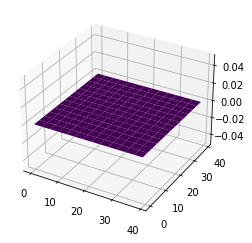

[ 0  1  2 ... 37 38 39]
[ 0  0  0 ... 39 39 39]


In [18]:
# Plot the discrete environment
width = height = 40 # Size of the environment
map = np.zeros((width,height))

def show_model(map):
    width = height = 40 # Size of the environment
    x = y = np.arange(width) # This only works if both have the same size
    X, Y = np.meshgrid(x, y) # generate grid
    # Write your code here for ploting the map using plot_surface (see 1_python_numpy_basics notebook)
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, map, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
    plt.show()
#     ax.contourf(X, Y, map, zdir='z', offset=-0.002, cmap=cm.viridis)
    
show_model(map)
X, Y = np.meshgrid(x, y)
print(X.flatten())
print(Y.flatten())

#### Sensor
Each agent $i$ has a range sensor on board able to detect people in the sea with probability $p$. The position of the agent  is $x=\{x_i,x_j\}$ (2D location). We are going to model the sensor in a probabilistic fashion. The sensor will return the probability of non-detecting the target. This is due to the utility function that we will see afterwards. Given the euclidean distance between the agent and the potential target location as $d$, the range sensor is modelled by the following equation:

$$p(\overline{D}) = 1 - P_{d_{max}} \exp\left[ -\sigma \left( \frac{d}{d_{max}}\right)^2 \right]$$

Note that we can compute the euclidian distance as $d = \sqrt{ (i-x_i)^2 +(j-x_j)^2}$ and $\exp$ is the exponential operator. 

Program and plot the non-detection sensor model. The plot should looks like this one:
<img src="img/pnd-sensor.png" width="400" />

Note that we can update the belief that the agent has about the world with observations using a Recursive Bayesian Estimator procedure. Here as the world is static we only need the update and not the prediction step.

The update for $N$ observations (N steps ahead) is as follows: 

$$ b^k = \left[ \prod_{j=1}^N P(\overline{D}|x^k, \tau) \right] b^{k-1} $$
Where $b^{k-1}$ is our prior belief of the target location $P(\tau)$ and $N$ is the number of observations. Here, we are assuming independence of the measures (observations).

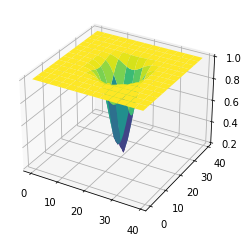

In [19]:
import math

# observation model
Pdmax = 0.8 # Max range sensor
dmax = 4 # Max distance
sigma = 0.7 # Sensor spread (standard deviation)
X, Y = np.meshgrid(x, y) 
x = [20,20] # Agent 2D location 
I = X.flatten() # Convert matrix into a single vector useful for operating 
J = Y.flatten() # Convert matrix into a single vector useful for operating 

## Write your code here
# Compute the sensor P(\overline{D}) with a function with name 
# def sensor_pnd( ... ):
def sensor_pnd(d, dmax, Pdmax, sigma):
    return 1 - Pdmax*math.exp(-sigma*(d/dmax)**2)

def distance(xi, xj, i, j):
    return math.sqrt((i - xi)**2 + (j - xj)**2)

# Plot the sensor
width = height = 40 # Size of the environment
map = np.zeros((width, height))
for i in I:
    for j in J:
        d = distance(x[0], x[1], i, j)
        map[i, j] = sensor_pnd(d, dmax, Pdmax, sigma)
        
show_model(map)


#### Agents
Each agent in the discrete version has its state defined as the 2D location $s$ at time $k$ ($s^k$) and a set of possible actions $u^k$. The grid and the possible actions are defined in the following figure:
<img src="img/actions-discrete.png" width="400" />

In [5]:
ndir = 9 # number of movements
delta = 0.5 # Constant displacement
# Define the 9 possible movements with an array of size(ndir,2) of delta increments
# Example to move up is -delta, 0

# Write your code here
mat = [[0, 0], [-delta, 0], [-delta, delta], [0, delta], [delta, delta], [delta, 0], [delta, -delta], [0, -delta], [-delta, -delta]]

print("Movements", mat)


# Given the state of the agent
x = [20,20] # agent state

# Write a function that computes all next movements or forward states (fs) using the np.random.permutation function 
# We use this randomization to avoid selecting the same action when all actions have the same utility
# Write the code of the function here
# def forward_states( ... ?):
# (Remember to remove outside grid (out of bound) movements with a  boolean mask)

def forward_states(x, mat):
    return np.random.permutation([[a+x[0], b+x[1]] for [a, b] in mat if a+x[0] >= 0 and a+x[0] < 40 and b+x[1] >= 0 and b+x[1] < 40])

fs = forward_states(x, mat)
print("Forward states", fs)


Movements [[0, 0], [-0.5, 0], [-0.5, 0.5], [0, 0.5], [0.5, 0.5], [0.5, 0], [0.5, -0.5], [0, -0.5], [-0.5, -0.5]]
Forward states [[19.5 20.5]
 [20.5 20.5]
 [20.5 20. ]
 [20.  19.5]
 [20.  20.5]
 [19.5 19.5]
 [20.  20. ]
 [19.5 20. ]
 [20.5 19.5]]


### Initial belief (prior information)

Our intel department has computed that the shipwreck is in the middle of our environment: $w/2, h/2$. We model the initial probability of the target location $P(\tau)$ with a bivariate Gaussian distribution $N(\mu, \Sigma)$ like the following:

<img src="img/b0.png" width="400" />


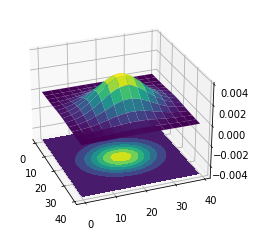

[[ 0  1  2 ... 37 38 39]
 [ 0  1  2 ... 37 38 39]
 [ 0  1  2 ... 37 38 39]
 ...
 [ 0  1  2 ... 37 38 39]
 [ 0  1  2 ... 37 38 39]
 [ 0  1  2 ... 37 38 39]]


In [20]:
# Compute the initial prior belief for the agent
w = h = 40 # Size of the world
mu = np.array([w/2., h/2.])# center point
Sigma = np.array([[40,0],[0,60]]) # Bimodal covariance with no dependence.

x = y = np.arange(w) # This only works if both have the same size
X, Y = np.meshgrid(x, y) # generate grid

# Write your code here for computing the bivariate Gaussian function 
# Tip: You should normalize the belief to sum to 1. You can divide the belief by its sum to obtain it
def bivariate_gaussian(w, h, mu, Sigma):
    COV_1 = np.linalg.inv(Sigma) # Compute the inverse Sigma^-1
    p = np.zeros(w*h) # probability map
    d = np.array([X.ravel()-mu[0],Y.ravel()-mu[1]]) # distances (x- \mu)
    # Compute probability of each point
    for i in range(0,w*h):
        p[i] = np.exp(- 0.5 * d[:,i].dot(COV_1).dot(d[:,i].transpose()))
    p = p/np.sum(p) # normalize to sum to 1
    P = p.reshape((w, h)) # rank 2 square matrix 
    return P

P = bivariate_gaussian(w, h, mu, Sigma)
# Plot the initial belief
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, P, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
cset = ax.contourf(X, Y, P, zdir='z', offset=-0.005, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.005,0.004)
ax.view_init(27, -21)
plt.show()
print(X)

### 2. One agent search greedy 1 step discrete

We will program one agent search algorithm with 1-step ahead discrete (greedy). The idea is to select the next state that maximize the utility function: to maximize the probability of finding the target.

**Tip: This is the same as maximizing the (1- probability of not finding the target)**

The algorithm is as follows:
1. Compute the possible next states
2. Compute the utility for each new state
3. Select the maximum utility state $\arg \max$
4. Move the agent and perform an observation
5. Go to step 1

#### Utility function

To evaluate "how good" is a state we compute how much information gain we accumulate we exerting an action. That is, an action $u$ is better if the probability of finding the target $\tau$ is higher than others. As we have deterministic actions: an action always arrives to the same state, we can model the utility function given the state as:

$$ U(x) = \left[ \sum_\tau^k p(\overline{D}| x^k,\tau) \right] b_\tau^{k-1}$$

This is the sum over all possible states of $\tau$ (marginalization) of the probability of non-detecting the target given the agent state and the target state.

Solving the problem is minimizing $U(x)$ or we can solve the maximization of $1-U(x)$.

In [7]:
# Program the utility computation for all possible forward states (using the previous agent code and prior initialization)
# You need to program the utility function and the function that returns the next best state

def utility(b, w, h, s):
    total = 0
    for x in range(w):
        for y in range(h):
            if s[0] != x or s[1] != y:
                total += b[x, y]
    return total

def next_best_state(b, w, h, s):
    min_utility, best_state = 100, [0, 0]
    for state in forward_states(s, mat):
        current_utility = utility(b, w, h, state)
        if min_utility > current_utility:
            min_utility, best_state = current_utility, state
    return best_state

# print("best state", xf)

### Algorithm

Write the full algorithm with a loop. Plot the agent trajectory as well as the belief map as in this figure:

<img src="img/solution.png" width="400" />

-------------------------------------------------

> One agent search 2D (greedy 1-step ahead)



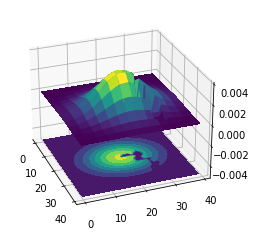

In [14]:
# Initialize variables and parameters
print('-------------------------------------------------\n');
print('> One agent search 2D (greedy 1-step ahead)\n')

# Initialize Agent
agent = [20, 20]

# Initialize Prior belief
b = bivariate_gaussian(w, h, mu, Sigma)

#Write the function that makes the agent search the environment

def agent_search(agent_state, belief, iterations):

    nite = iterations # Number of steps computed
    ite = 0  # Current iteration
    found = 0 # Not used in this code
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    while (not found and ite < nite):
        # compute discrete forward states
        # compute utility function of the potential forward states brute force method
        # selection of action/state with max information gain
        # simulate agent movement
        agent_state = next_best_state(belief, w, h, agent_state)
#         print(agent_state)

        # update belief with the new observation (non-detection)
        belief[math.floor(agent_state[0]), math.floor(agent_state[1])] = 0

        # normalize belief
        belief = belief/np.sum(belief)
#         print(belief[math.floor(agent_state[0]), math.floor(agent_state[1])])

        # plot belief and trajectory
        ax.plot_surface(X, Y, belief, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
        cset = ax.contourf(X, Y, belief, zdir='z', offset=-0.005, cmap=cm.viridis)

        # Adjust the limits, ticks and view angle
        ax.set_zlim(-0.005,0.004)
        ax.view_init(27, -21)

#         plt.show()
#         plt.pause(0.1) # animation not needed in the jupyter notebook

        # iteration count
        ite +=1
            
# execute the function agent_search
agent_search(agent, b, 200)
# next_best_state(b, w, h, [0., 0.])
# for state in forward_states([10., 10.], mat):
#     print(state)
#     print(utility(b, w, h, state))